# the backprop algorithm

Note the use of "checkgrad", which exhaustively confirms that the gradient calculation is in fact correct - not something to run all the time but a useful check to have.

Issues:
  * the neural net has no biases yet
  * the learning problem is just random - better if we could read in a training set

In [1]:
import numpy as np
import numpy.random as rng
import sklearn
import sklearn.datasets as ds
import sklearn.cross_validation as cv
import sklearn.neighbors as nb
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(precision=2,suppress=True) #prints floats shorter

### specify a neuron transfer function ('f'), and its derivative ('df')

In [2]:
# THESE FUNCTIONS MUST MATCH ONE ANOTHER................

def f( phi, transfer='linear'): 
    npats, nunits = phi.shape
    # phi is always going to be a weighted sum (probably a matrix of).
    if (transfer == 'linear'): return (phi)
    elif (transfer == 'sigmoid'): return (1.0/ (1.0 + np.exp(-phi)))
    elif  (transfer == 'relu'): return (phi * (phi>0.0))
    elif  (transfer == 'softmax'): 
        # get the max for each row, and reshape so it broadcasts nice.
        shift = phi.max(axis=1).reshape((npats,1)) 
        ePhi = np.exp(phi-shift) # so the max in exp is 0.
        Z = ePhi.sum(axis=1).reshape((npats,1))
        return (ePhi/Z)
    else: return None

def df( x, transfer='linear'):  
    # MUST MATCH WHAT YOU PUT HERE with the f function.
    # This is the gradient of the transfer function
    # with respect to "phi", the weighted sum of inputs to the neuron.
    #
    # IMPORTANT: NOTE that unlike f(), the input argument isn't phi 
    # here - it's the function value itself after going thru non-linearity.

    if (transfer == 'linear'): 
        return (np.ones(shape=x.shape,dtype=float))
        # return (1.0)  would probably work just the same!
    elif (transfer == 'sigmoid'): return (x*(1.0-x))
    elif  (transfer == 'relu'): return (1.0*(x>0.0))
    elif  (transfer == 'softmax'): return (x*(1.0-x))
    else: return None


### get or make some training data
Got to have something to work on.

In [3]:
# I'm going to be dumb here and make them from my very own random perceptrons!
# However you do it, call the input patterns "inputX" (each row is a pattern), and the output patterns "targets".
Nins, Nouts, Npats = 50, 5, 1000
inputX = rng.normal(0,1,size=(Npats,Nins))
inputX = inputX - inputX.mean(axis=0)  # mean zero
inputX = inputX / np.sqrt(inputX.var(axis=0)) # variance one
#print (inputX[:3, :]) # just a sanity check
print ('input means: ',inputX.mean())
print ('input variances: ',inputX.var())
Targ = np.zeros((Npats,Nouts))

tmpNhids = 10
tmp_weights = 1./Nins  * rng.normal(0,1,size=(Nins,tmpNhids))
hidphi = np.dot(inputX, tmp_weights)
H = f(hidphi,'sigmoid')
tmp_weights = 1./np.sqrt(tmpNhids) * rng.normal(0,1,size=(tmpNhids,Nouts))
outphi = np.dot(H, tmp_weights)

## NOTE sampling of Targ should reflect choice of y transfer fn here:
y = f(10.*outphi, 'softmax')
for n in range(Npats):
    t = np.random.choice(Nouts, 1, p=y[n]) # choose from Categorical
    Targ[n,t]=1

#print (y[:3, :]) # just a sanity check
#print (Targ[:3, :]) # just a sanity check

input means:  -8.5798035343e-18
input variances:  1.0


In [4]:
# That's groovy for testing: you can give the learner net the 
# same structure and it should "get there" reliably.
#
# But it would be more interesting to use some realistic data too.
# This is a classification dataset, so we should have softmax for the output).
if True:
    digits = ds.load_digits()
    inputX = digits.data
    Npats = inputX.shape[0]
    inputX = inputX - inputX.mean(axis=0)  # mean zero
    max_in, min_in = inputX.ravel().max(), inputX.ravel().min() 
    inputX = 2.0*(inputX - min_in)/(max_in - min_in) - 1.0
    print (np.where(inputX.var(axis=0) == 0.0))
    #assert np.all(inputX.var(axis=0)), 'some inputs have no variance!'
    #inputX = inputX / np.sqrt(inputX.var(axis=0)) # variance one
    
    target_classes = digits.target  # currently a vector - but we want a nx1 matrix,so...
    Nouts = np.max(target_classes)+1
    Targ = np.zeros((Npats,Nouts)) 
    for n in range(Npats):  # There has to be a better way by anyways...
        t = target_classes[n]
        Targ[n,t]=1
    print(inputX.shape, Targ.shape)
    print(inputX.min(), inputX.max())
    print(Targ[:5])

(array([], dtype=int64),)
(1797, 64) (1797, 10)
-1.0 1.0
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


In [5]:
Npats, Nins = inputX.shape
Nouts = Targ.shape[1]
print('Nins: %d, Nouts: %d, Npats: %d' % (Nins, Nouts, Npats))

Nins: 64, Nouts: 10, Npats: 1797


### set the network's architecture

In [6]:
def initialise_net_structure(inputX, architecture, transfer_func):

    Nlayers = len(architecture)
    assert len(transfer_func) == Nlayers, 'you need a transfer function for every layer'
    assert not((Nouts==1) and (transfer_func[-1]=='softmax')), 'softmax of 1 output makes no sense!'
    print ('There are this many neurons in each layer: ', architecture)  # a list of the number of neurons in each layer
    print ('Transfer of each processing layer: ', transfer_func[1:]) 

    X = [inputX] 
    # X is going to be a list giving the activations of successive layers. 
    # Each one is a matrix, whose columns are the neurons in that layer.
    # Each row in the matrix corresponds to a training item.
    # So all the matrices in the list X will have the same number of rows.

    for L in range(1, len(architecture)):
        X.append(np.zeros(shape=(Npats, architecture[L]), dtype=float))

    for L in range(len(architecture)): 
        print('layer %d activations have shape ' %(L), X[L].shape)
    
    return X

In [7]:
arch  = [Nins, 10, Nouts]  # here, small and simple as it's a test.
trans = ['linear', 'sigmoid', 'softmax'] 
# NOTE: first is ALWAYS linear, as it's just the input itself.
# I don't think I use it anywhere, anyway!
X = initialise_net_structure(inputX, arch, trans)

There are this many neurons in each layer:  [64, 10, 10]
Transfer of each processing layer:  ['sigmoid', 'softmax']
layer 0 activations have shape  (1797, 64)
layer 1 activations have shape  (1797, 10)
layer 2 activations have shape  (1797, 10)


### set up the weights

In [8]:
# Then we have the weights. I'm going to index the weight layer 
# according to the layer they're *coming from*.
# So I'll have a zeroth weight layer.
# NOTE: no implementation of bias weights here, yet!
def initialise_weights(X):
    W  = [] #[np.array(None)]
    for L in range(0,len(X)-1):
        init_weights_scale = 0.1  #1/np.sqrt((X[L].shape()).max())

        Nins = X[L].shape[1]
        Nouts = X[L+1].shape[1]
        W.append(init_weights_scale * rng.normal(0,1,size=(Nouts, Nins)) )

    for L in range(len(W)):
        print('layer %d weights have shape ' %(L), W[L].shape)
        
    # while we're at it, make space for the gradients so we're not constantly reallocating
    dW = []
    for w in W:
        dW.append(np.zeros(w.shape, dtype=float))
        
    return W, dW

In [9]:
       
W, dW = initialise_weights(X)

layer 0 weights have shape  (10, 64)
layer 1 weights have shape  (10, 10)


### The function we're climbing

In [10]:
def calc_goodness(Y, Targ, output_function='linear'):  
    # often this is called the "Loss" or the "Cost function" 
    # (and given a minus sign accordingly).
    # Y and Targ are matrices of shape (Npats, Nouts).
    #
    # dGoodness is the gradient w.r.t. the phi of the output layer,
    # where phi is the weighted sum into each of those output units.
    # GOTCHA: this means that in backprop, we won't need to push the 
    # gradients through the non-linearity of the output layer: they've 
    # already done that, here.
    if (output_function in ['linear','relu']):
        Goodness_vec = -0.5*np.power(Targ - Y, 2.0) # inverted parabola centered on the target outputs
        dGoodness_vec = Targ - Y
        
    elif (output_function == 'sigmoid'): 
        Goodness_vec = Targ * np.log(Y)  +  (1-Targ) * np.log(1-Y) 
        dGoodness_vec = Targ - Y

    elif (output_function == 'softmax'):  # for softmax though it's going to be...
        Goodness_vec = np.multiply(Targ, np.log(Y))
        dGoodness_vec = Targ - Y

    # TESTING...
    #Goodness_vec = np.ones(shape=Targ.shape, dtype=float)
    #dGoodness_vec = 0.0*np.ones(shape=Targ.shape, dtype=float)
    return Goodness_vec.sum(), Goodness_vec, dGoodness_vec

# quick dumb test
print(calc_goodness(np.arange(1,5), np.arange(1,5)+1))

(-2.0, array([-0.5, -0.5, -0.5, -0.5]), array([1, 1, 1, 1]))


### forward pass
Notation:
   * superscript $l$ denotes the layer
   * $\Phi$ is weighted sum (as a vector over all units in a layer)
   * $f_l(\Phi)$ denotes the transfer function in use at layer $l$

So the forward pass through a layer can be written as a $\Phi^{l} \longrightarrow \Phi^{l+1}$ function:

$$ \Phi^{l+1} = W^{l} \cdot f_{l}(\Phi^{l}) $$
where the dot stands for matrix multiplication.

It's fun to write this out "long hand" like this;

$$\begin{align} 
\Phi^{L} &= W^{L-1} \cdot f_{L-1}(\Phi^{L-1})  
\\
&= W^{L-1} \cdot f_{L-1}\big(W^{L-2} \cdot f_{L-2}(\Phi^{L-2}) \big) 
\\
&= W^{L-1} \cdot f_{L-1}\big(W^{L-2} \cdot f_{L-2}\big(W^{L-3} \cdot f_{L-3}\big(\Phi^{L-3}\big)\big) \big) 
\end{align} $$


In [11]:
def forward_pass(X, W, transfer_fns):
    for layer in range(1,len(X)):
        phi = np.dot(W[layer-1], X[layer-1].transpose()).transpose()
        X[layer] = f(phi, transfer_fns[layer])
    return X

### backward pass
Notation:
   * here I'll use $\mathcal{L}$ as the loss. In the code I talk about "goodness", but just insert a minus if you want to convert!...
   * capital $L$ refers to the final layer, where outputs are generated.
   * let's denote the number of units in layer $l$ as $N^l$.
   
By the chain rule, the whole gradient for some weights in layer $l$ is:

$$ \frac{\partial \mathcal{L}}{\partial \Phi^l} = \underbrace{\frac{\partial \mathcal{L}}{\partial \Phi^L}}_\text{A} \; \cdot \; \underbrace{\frac{\partial \Phi^{L}}{\partial \Phi^{L-1}} \cdots \frac{\partial \Phi^{l+2}}{\partial \Phi^{l+1}}}_\text{B}  \; \cdot \; \underbrace{\frac{\partial \Phi^{l+1}}{\partial W^{l}}}_\text{C} $$

In this "vectorial" form this looks nice and compact. Remember each of these is really a matrix though. The numerator's vector elements are rows, the denominator elts are columns of this matrix. So: 
   * A's shape is $(1 \times N^L)$. 
   * B's shapes are $(N^{L} \times N^{L-1})$, \;...\; ,$(N^{l+2} \times N^{l+1})$.
   * C is a tensor (matrix with 3 axes) with shape $(N^{l+1} \times \underbrace{N^{l+1} \times N^{l}}_\text{shape of $W^l$})$ 



B has a recursive flavour: the gradient is pushed back through each layer in turn. What happens to it along the way?
By the chain rule as usual:

$\displaystyle\frac{\partial \Phi^{l+1}}{\partial \Phi^{l}} = W^{l} \cdot \frac{\partial f^{l}}{\partial \phi} \bigg|_{\phi=\Phi^{l}}$

ie. we take the gradient of the transfer function, evaluated at $\Phi^{l}$, and push it back through the weights matrix. I've written it all as a vector here: if that's confusing try doing it for a specific element, and then convince yourself that it can be "vectorised".


So the backward pass through a layer can be written as a $\Phi^{l} \longrightarrow \Phi^{l+1}$ function:

$$ \Phi^{l+1} = W^{l} \cdot f_{l}(\Phi^{l}) $$

In [12]:
def backward_pass(X, W, targets, transfer_fns):
    """ Calculates the gradient of every weight in the network"""
    g1, g2, dgood = calc_goodness(X[-1], targets, transfer_fns[-1])
    epsilon = dgood
    for L in range(len(W), 0, -1):
        if L==len(W):
            psi = epsilon #it has already been through transfer fn...
        if L<len(W):
            psi = epsilon * df(X[L], transfer_fns[L]) # elt-wise multiply
        n1, n2 = X[L-1].shape[1], psi.shape[1]
        A = np.tile(X[L-1],n2).reshape(Npats,n2,n1)
        B = np.repeat(psi,n1).reshape(Npats,n2,n1)        
        dW[L-1] = (A*B).sum(0) # outer product multiply
        epsilon = np.dot(psi, W[L-1]) # inner product multiply
    return dW

In [13]:
X = forward_pass(X, W, trans)
dW = backward_pass(X, W, Targ, trans)

In [14]:
def checkgrad(dW, X, W, targets, transfer_fns):
    # Check the gradient directly, via perturbations to every weight.
    # This is completely daft in practical terms, but very useful for debugging.
    # ie. it tells you whether your backprop of errors really is returning the true gradient.
    tiny = 0.00000001
    
    dW_test = []
    for w in W:
        dW_test.append(np.zeros(w.shape, dtype=float))

    X = forward_pass(X,W, transfer_fns)
    base_good, tmp1, tmp2 = calc_goodness(X[-1], targets, transfer_fns[-1])
    
    for L in range(0,len(W)):
        for j in range(W[L].shape[0]): # index of destination node
            for i in range(W[L].shape[1]): # index of origin node
                # perturb that weight
                (W[L])[j,i] = (W[L])[j,i] + tiny
                # compute and store the empirical gradient estimate
                X = forward_pass(X, W, transfer_fns)
                tmp_good, tmp1, tmp2 = calc_goodness(X[-1], targets, transfer_fns[-1])
                (dW_test[L])[j,i] = (tmp_good - base_good)/tiny                
                # unperturb the weight
                (W[L])[j,i] = (W[L])[j,i] - tiny
                
    # show the result?
    for L in range(0,len(W)):
        print ('Layer %d max disagreement: %f'  % (L, ((np.abs(dW[L] - dW_test[L])).ravel().max())))
        #print ('-------------- layer %d --------------' %(L))
        #print ('calculated gradients:')
        #print (dW[L])
        #print ('empirical gradients:')
        #print (dW_test[L])        

Checkgrad is slow, so I'll try it only for small nets.

In [15]:
checkgrad(dW, X, W, Targ, trans)

Layer 0 max disagreement: 0.000112
Layer 1 max disagreement: 0.000124


## yay.
The gradient seems to be right for the full MLP, so that's... progress!

Let's try learning the problem then....

In [16]:
def learn(X, W, targets, transfer_fns, learning_rate=0.01, momentum=0.1, num_steps=1):
    # note dW and prev_change are of the same size as W - we'll make space for them first
    times, vals = [], []
    next_time = 0
    How_Often = 1 # how often to report progress points
    
    # make space for saving changes to weights, and initialise to zero.
    prev_change = []
    for L in range(0,len(W)):
        prev_change.append(0.0 * np.copy(W[L]))
    
    # now for the learning iterations
    for step in range(num_steps):
        X = forward_pass(X, W, transfer_fns)
        
        # this is just record-keeping.......
        if step == next_time:
            good_sum, good_vec, dgood = calc_goodness(X[-1], targets, transfer_fns[-1])
            vals.append(good_sum)
            times.append(step)
            next_time = step + How_Often

        dW = backward_pass(X, W, targets, transfer_fns)
        
        for L in range(0,len(W)):
            change =  (learning_rate * dW[L]) + (momentum * prev_change[L])
            W[L] = W[L] + change
            prev_change[L] = change

    return W, times, vals

## Train new network with random weights


In [17]:
arch  = [Nins, 20, 10,  Nouts]
trans = ['linear', 'sigmoid', 'sigmoid', 'softmax'] 
X = initialise_net_structure(inputX, arch, trans)
W, dW = initialise_weights(X)

There are this many neurons in each layer:  [64, 20, 10, 10]
Transfer of each processing layer:  ['sigmoid', 'sigmoid', 'softmax']
layer 0 activations have shape  (1797, 64)
layer 1 activations have shape  (1797, 20)
layer 2 activations have shape  (1797, 10)
layer 3 activations have shape  (1797, 10)
layer 0 weights have shape  (20, 64)
layer 1 weights have shape  (10, 20)
layer 2 weights have shape  (10, 10)


#### Do it.
Run this next cell as often as you want, as learning picks up where it left off.

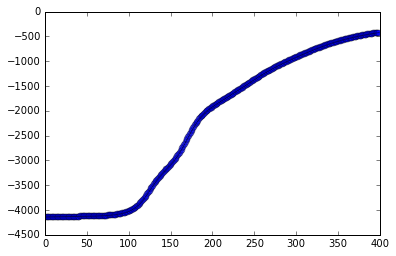

In [18]:
W, times, vals = learn(X, W, Targ, trans, 
                       learning_rate=0.0001, 
                       momentum=0.9, 
                       num_steps=400)

plt.plot(times, vals, 'ob',  times, vals, '-k', alpha=0.5)